In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import seaborn as sns
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [60]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Input
from keras.layers import Embedding,LSTM,GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import Model

import os

In [101]:
twit = pd.read_csv('train.csv')

In [56]:
twit.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
twit_df = twit.drop(columns = ['id','keyword','location'])

In [6]:
twit_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
pd.value_counts(twit_df['target'])

0    4342
1    3271
Name: target, dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
print(len(nlp.Defaults.stop_words))
stopwords = (nlp.Defaults.stop_words)

326


In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S\s+')
    return url.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
    
def stop_words(text):
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

In [11]:
twit_df['text'] = twit_df['text'].apply(remove_URL)

In [12]:
twit_df['text'] = twit_df['text'].apply(remove_emoji)

In [13]:
twit_df['text'] = twit_df['text'].map(lambda x: remove_punct(x))

In [14]:
twit_df['text'] = twit_df['text'].map(lambda x: x.lower())

In [15]:
twit_df['text'] = twit_df['text'].apply(stop_words)

In [16]:
twit_df['text'][0:5]

0                deeds reason earthquake allah forgive
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [24]:
X = twit_df['text']
y = twit_df['target']

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [37]:
print(X_train.head())
print(X_train.shape)
print('\n\n')

print(y_train.head())

print('\n\n')

print(X_val.head())
print(X_val.shape)

print('\n\n')

print(y_val.head())

1186    ashes australiaûªs collapse trent bridge wors...
4071    great michigan technique camp bg thanks bmurph...
5461    cnn tennessee movie theater shooting suspect k...
5787                      rioting couple hours left class
7445    crack path wiped morning beach run surface wou...
Name: text, dtype: object
(5329,)



1186    0
4071    1
5461    1
5787    1
7445    0
Name: target, dtype: int64



2644            new weapon cause unimaginable destruction
2227    famping things gishwhes got soaked deluge goin...
5448    dt georgegalloway rt gallowaymayor ûïthe col ...
132     aftershock school kick great want thank making...
6845    response trauma children addicts develop defen...
Name: text, dtype: object
(2284,)



2644    1
2227    0
5448    1
132     0
6845    0
Name: target, dtype: int64


In [27]:
from keras.preprocessing.text import Tokenizer

In [40]:
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [52]:
word2idx = tokenizer.word_index

print(X_train_seq[0])
v= len(word2idx)
v
#print(X_val_seq)

[760, 3169, 68, 978, 367, 646, 429, 1217, 3170, 699]


13508

#setting the hyperparameters

output_dir = 'model_output/dense'

epochs = 10
batch_size = 128

#vector spacing embedding
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50
pad_type = trunc_type = 'pre'

#Neural network architecture:

n_dense = 64
dropout = 0.5


In [71]:
#standardize input length by padding and trucating

X_train_data = pad_sequences(X_train_seq)

T = X_train_data.shape[1]

X_val_data= pad_sequences(X_val_seq,maxlen=T)

In [72]:
print(X_val_data.shape)

(2284, 21)


In [61]:

D = 20
M=15


i = Input(shape=(T,))
x = Embedding(v+1,D)(i)
x = LSTM(M,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1,activation = 'sigmoid')(x)

model = Model(i,x)



In [62]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 21, 20)            270180    
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 15)            2160      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 272,356
Trainable params: 272,356
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [64]:
output_dir = 'model_output/dense'

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [76]:
r = model.fit(X_train_data,y_train,epochs=10,verbose=1,
         validation_data=(X_val_data,y_val),
         callbacks=[modelcheckpoint])

Train on 5329 samples, validate on 2284 samples
Epoch 1/10
5329/5329 [==============================] - ETA: 4s - loss: 0.0332 - accuracy: 1.00 - ETA: 5s - loss: 0.0269 - accuracy: 0.98 - ETA: 5s - loss: 0.0301 - accuracy: 0.98 - ETA: 5s - loss: 0.0287 - accuracy: 0.99 - ETA: 5s - loss: 0.0351 - accuracy: 0.98 - ETA: 5s - loss: 0.0312 - accuracy: 0.99 - ETA: 5s - loss: 0.0280 - accuracy: 0.99 - ETA: 5s - loss: 0.0259 - accuracy: 0.99 - ETA: 5s - loss: 0.0269 - accuracy: 0.99 - ETA: 5s - loss: 0.0287 - accuracy: 0.99 - ETA: 5s - loss: 0.0267 - accuracy: 0.99 - ETA: 5s - loss: 0.0271 - accuracy: 0.99 - ETA: 4s - loss: 0.0290 - accuracy: 0.99 - ETA: 4s - loss: 0.0315 - accuracy: 0.98 - ETA: 4s - loss: 0.0299 - accuracy: 0.99 - ETA: 4s - loss: 0.0300 - accuracy: 0.98 - ETA: 4s - loss: 0.0290 - accuracy: 0.99 - ETA: 4s - loss: 0.0287 - accuracy: 0.99 - ETA: 4s - loss: 0.0300 - accuracy: 0.98 - ETA: 4s - loss: 0.0291 - accuracy: 0.99 - ETA: 4s - loss: 0.0293 - accuracy: 0.99 - ETA: 4s - loss

5329/5329 [==============================] - ETA: 5s - loss: 0.0186 - accuracy: 1.00 - ETA: 5s - loss: 0.0135 - accuracy: 1.00 - ETA: 5s - loss: 0.0172 - accuracy: 1.00 - ETA: 5s - loss: 0.0195 - accuracy: 0.99 - ETA: 5s - loss: 0.0271 - accuracy: 0.98 - ETA: 5s - loss: 0.0278 - accuracy: 0.98 - ETA: 5s - loss: 0.0270 - accuracy: 0.98 - ETA: 5s - loss: 0.0262 - accuracy: 0.98 - ETA: 5s - loss: 0.0250 - accuracy: 0.98 - ETA: 5s - loss: 0.0260 - accuracy: 0.98 - ETA: 5s - loss: 0.0250 - accuracy: 0.98 - ETA: 5s - loss: 0.0252 - accuracy: 0.98 - ETA: 4s - loss: 0.0246 - accuracy: 0.98 - ETA: 4s - loss: 0.0255 - accuracy: 0.98 - ETA: 4s - loss: 0.0252 - accuracy: 0.98 - ETA: 4s - loss: 0.0245 - accuracy: 0.98 - ETA: 4s - loss: 0.0252 - accuracy: 0.98 - ETA: 4s - loss: 0.0247 - accuracy: 0.98 - ETA: 4s - loss: 0.0299 - accuracy: 0.98 - ETA: 4s - loss: 0.0298 - accuracy: 0.98 - ETA: 4s - loss: 0.0286 - accuracy: 0.98 - ETA: 4s - loss: 0.0275 - accuracy: 0.98 - ETA: 4s - loss: 0.0270 - accura

5329/5329 [==============================] - ETA: 6s - loss: 0.0046 - accuracy: 1.00 - ETA: 6s - loss: 0.0047 - accuracy: 1.00 - ETA: 5s - loss: 0.0196 - accuracy: 0.98 - ETA: 5s - loss: 0.0195 - accuracy: 0.99 - ETA: 5s - loss: 0.0197 - accuracy: 0.99 - ETA: 5s - loss: 0.0213 - accuracy: 0.99 - ETA: 5s - loss: 0.0190 - accuracy: 0.99 - ETA: 5s - loss: 0.0236 - accuracy: 0.98 - ETA: 5s - loss: 0.0223 - accuracy: 0.98 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0201 - accuracy: 0.99 - ETA: 5s - loss: 0.0199 - accuracy: 0.99 - ETA: 4s - loss: 0.0185 - accuracy: 0.99 - ETA: 4s - loss: 0.0183 - accuracy: 0.99 - ETA: 4s - loss: 0.0185 - accuracy: 0.99 - ETA: 4s - loss: 0.0191 - accuracy: 0.99 - ETA: 4s - loss: 0.0200 - accuracy: 0.99 - ETA: 4s - loss: 0.0193 - accuracy: 0.99 - ETA: 4s - loss: 0.0191 - accuracy: 0.99 - ETA: 4s - loss: 0.0187 - accuracy: 0.99 - ETA: 4s - loss: 0.0181 - accuracy: 0.99 - ETA: 4s - loss: 0.0182 - accuracy: 0.99 - ETA: 4s - loss: 0.0179 - accura

5329/5329 [==============================] - ETA: 5s - loss: 0.0366 - accuracy: 1.00 - ETA: 6s - loss: 0.0286 - accuracy: 0.98 - ETA: 6s - loss: 0.0275 - accuracy: 0.98 - ETA: 5s - loss: 0.0277 - accuracy: 0.98 - ETA: 5s - loss: 0.0298 - accuracy: 0.98 - ETA: 5s - loss: 0.0294 - accuracy: 0.98 - ETA: 5s - loss: 0.0271 - accuracy: 0.98 - ETA: 5s - loss: 0.0279 - accuracy: 0.98 - ETA: 5s - loss: 0.0264 - accuracy: 0.98 - ETA: 5s - loss: 0.0261 - accuracy: 0.98 - ETA: 5s - loss: 0.0268 - accuracy: 0.98 - ETA: 4s - loss: 0.0250 - accuracy: 0.98 - ETA: 4s - loss: 0.0232 - accuracy: 0.98 - ETA: 4s - loss: 0.0228 - accuracy: 0.98 - ETA: 4s - loss: 0.0225 - accuracy: 0.98 - ETA: 4s - loss: 0.0235 - accuracy: 0.98 - ETA: 4s - loss: 0.0237 - accuracy: 0.98 - ETA: 4s - loss: 0.0227 - accuracy: 0.98 - ETA: 4s - loss: 0.0223 - accuracy: 0.98 - ETA: 4s - loss: 0.0224 - accuracy: 0.98 - ETA: 4s - loss: 0.0216 - accuracy: 0.98 - ETA: 4s - loss: 0.0208 - accuracy: 0.98 - ETA: 4s - loss: 0.0216 - accura

5329/5329 [==============================] - ETA: 5s - loss: 0.0269 - accuracy: 1.00 - ETA: 5s - loss: 0.0179 - accuracy: 1.00 - ETA: 5s - loss: 0.0378 - accuracy: 0.98 - ETA: 5s - loss: 0.0380 - accuracy: 0.98 - ETA: 5s - loss: 0.0393 - accuracy: 0.97 - ETA: 5s - loss: 0.0343 - accuracy: 0.98 - ETA: 5s - loss: 0.0328 - accuracy: 0.98 - ETA: 5s - loss: 0.0330 - accuracy: 0.98 - ETA: 5s - loss: 0.0345 - accuracy: 0.98 - ETA: 5s - loss: 0.0347 - accuracy: 0.98 - ETA: 4s - loss: 0.0319 - accuracy: 0.98 - ETA: 4s - loss: 0.0306 - accuracy: 0.98 - ETA: 4s - loss: 0.0284 - accuracy: 0.98 - ETA: 4s - loss: 0.0278 - accuracy: 0.98 - ETA: 4s - loss: 0.0264 - accuracy: 0.99 - ETA: 4s - loss: 0.0267 - accuracy: 0.98 - ETA: 4s - loss: 0.0258 - accuracy: 0.98 - ETA: 4s - loss: 0.0248 - accuracy: 0.99 - ETA: 4s - loss: 0.0262 - accuracy: 0.98 - ETA: 4s - loss: 0.0258 - accuracy: 0.98 - ETA: 4s - loss: 0.0255 - accuracy: 0.98 - ETA: 4s - loss: 0.0247 - accuracy: 0.98 - ETA: 4s - loss: 0.0243 - accura

In [100]:
cv_scores = classification_report(y_hat,y_val)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [75]:
import matplotlib.pyplot as plt

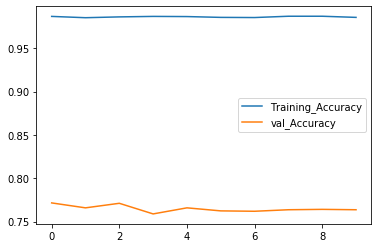

In [78]:
plt.plot(r.history['accuracy'],label = 'Training_Accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_Accuracy')
plt.legend()

In [82]:
model.load_weights(output_dir+"/weights.03.hdf5")

In [84]:
y_hat = model.predict(X_val_data)

In [92]:
#''.join(index_word[id] for id in X_val[0])

In [94]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])


In [95]:
ydf = pd.DataFrame(list(zip(float_y_hat,y_val)),columns=['y_hat','y_val'])

In [96]:
ydf.head()

,y_hat,y_val
0,0.017360,1
1,0.648535,0
2,0.072800,1
3,0.000778,0
4,0.152716,0


In [97]:
from sklearn.metrics import classification_report

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [33]:
#classifier Architecture:

model = Sequential()
model.add(Embedding(n_unique_words,n_dim,input_length=max_twit_length))
model.add(Flatten())
model.add(Dense(n_dense,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [34]:
#compiling the classifier

model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
#checkpoint after each epoch

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [38]:
#fitting classifier

model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,
         validation_data=(X_val,y_val),
         callbacks=[modelcheckpoint])

ValueError: Error when checking input: expected embedding_1_input to have shape (100,) but got array with shape (1,)